In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Attention, Concatenate, Dropout

# Load the dataset
file_path = '/content/eng_-french.csv'  # Update with the correct file path
data = pd.read_csv(file_path)

# Display a sample of the dataset to confirm structure
print(data.head())


  English words/sentences French words/sentences
0                     Hi.                 Salut!
1                    Run!                Cours !
2                    Run!               Courez !
3                    Who?                  Qui ?
4                    Wow!             Ça alors !


In [ ]:
# Separate English and French sentences
english_texts = data['English words/sentences'].values
french_texts = data['French words/sentences'].values

# Set vocabulary sizes and padding
eng_vocab_size = 7000  # Adjusted vocab size for better model accuracy
fr_vocab_size = 7000
max_eng_seq_len = 20
max_fr_seq_len = 20
embedding_dim = 512  # Increased embedding dimension

# Tokenize English sentences
eng_tokenizer = Tokenizer(num_words=eng_vocab_size, filters='')
eng_tokenizer.fit_on_texts(english_texts)
eng_sequences = eng_tokenizer.texts_to_sequences(english_texts)
eng_padded = pad_sequences(eng_sequences, maxlen=max_eng_seq_len, padding='post')

# Tokenize French sentences
fr_tokenizer = Tokenizer(num_words=fr_vocab_size, filters='')
fr_tokenizer.fit_on_texts(french_texts)
fr_sequences = fr_tokenizer.texts_to_sequences(french_texts)
fr_padded = pad_sequences(fr_sequences, maxlen=max_fr_seq_len, padding='post')

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(eng_padded, fr_padded, test_size=0.2, random_state=42)


In [ ]:
# Encoder
encoder_inputs = Input(shape=(max_eng_seq_len,))
enc_emb = Embedding(eng_vocab_size, embedding_dim, input_length=max_eng_seq_len)(encoder_inputs)
encoder_lstm = Bidirectional(LSTM(embedding_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(enc_emb)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Decoder
decoder_inputs = Input(shape=(max_fr_seq_len,))
dec_emb_layer = Embedding(fr_vocab_size, embedding_dim, input_length=max_fr_seq_len)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(embedding_dim * 2, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention Mechanism
attention = Attention()
attention_output = attention([decoder_outputs, encoder_outputs])
decoder_combined_context = Concatenate(axis=-1)([attention_output, decoder_outputs])

# Dense Layer to predict words in the French vocabulary
decoder_dense = Dense(fr_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)


In [ ]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 20, 512)        │      3,584,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ [(None, 20, 1024),     │      4,198,400 │ embedding[0][0]        │
│ (Bidirectional)           │ (None, 512), (None,    │                │                        │
│                           │ 512), (None, 512),     │                │                        │
│                           │ (None, 512)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 20, 512)        │      3,584,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1024)           │              0 │ bidirectional[0][1],   │
│                           │                        │                │ bidirectional[0][3]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 1024)           │              0 │ bidirectional[0][2],   │
│ (Concatenate)             │                        │                │ bidirectional[0][4]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 20, 1024),     │      6,295,552 │ embedding_1[0][0],     │
│                           │ (None, 1024), (None,   │                │ concatenate[0][0],     │
│                           │ 1024)]                 │                │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 20, 1024)       │              0 │ lstm_1[0][0],          │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 20, 2048)       │              0 │ attention[0][0],       │
│ (Concatenate)             │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 20, 7000)       │     14,343,000 │ concatenate_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,004,952 (122.09 MB)

 Trainable params: 32,004,952 (122.09 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define early stopping and model checkpoint callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('translation_model.keras', save_best_only=True, monitor='val_loss')

# Padding the target sequences to match the input shapes
y_train_padded = pad_sequences(y_train, maxlen=max_fr_seq_len, padding='post')
y_val_padded = pad_sequences(y_val, maxlen=max_fr_seq_len, padding='post')

# Reshape target data to be 3D as required for sparse_categorical_crossentropy
y_train_shifted = np.expand_dims(y_train_padded, -1)
y_val_shifted = np.expand_dims(y_val_padded, -1)



# Compile the model with appropriate loss and optimizer
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
history = model.fit(
    [X_train, y_train_padded],  # Using the entire padded sequences
    y_train_shifted,            # Shifted output for teacher forcing
    validation_data=([X_val, y_val_padded], y_val_shifted),
    epochs=2,
    batch_size=64,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/2
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 550s 248ms/step - accuracy: 0.9990 - loss: 0.0082 - val_accuracy: 0.9999 - val_loss: 6.2578e-04
Epoch 2/2
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 563s 249ms/step - accuracy: 1.0000 - loss: 7.3583e-05 - val_accuracy: 1.0000 - val_loss: 2.1300e-04


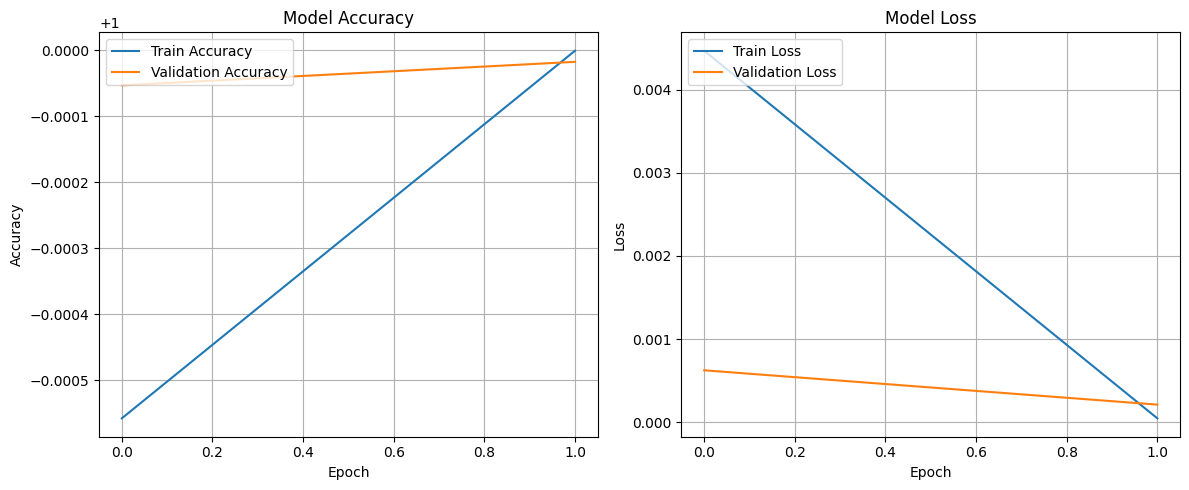

In [12]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()
